In [1]:
import warnings

import pennylane as qml
from pennylane.operation import AnyWires, Operation
from pennylane.templates.state_preparations.mottonen import compute_theta, gray_code
from pennylane.wires import Wires

import numpy as np
import matplotlib.pyplot as plt

import torch

In [47]:
# type: ignore


class FABLE(Operation):

    num_wires = AnyWires

    num_params = 1

    grad_method = None

    def __init__(self, input_matrix, wires, tol=0, id=None):
        wires = Wires(wires)
        if not qml.math.is_abstract(input_matrix):
            if qml.math.any(qml.math.iscomplex(input_matrix)):
                raise ValueError(
                    "Support for imaginary values has not been implemented."
                )

            alpha = qml.math.linalg.norm(qml.math.ravel(input_matrix), np.inf)
            if alpha > 1:
                raise ValueError(
                    "The subnormalization factor should be lower than 1."
                    + "Ensure that the values of the input matrix are within [-1, 1]."
                )
        else:
            if tol != 0:
                raise ValueError(
                    "JIT is not supported for tolerance values greater than 0. Set tol = 0 to run."
                )

        batch, row, col = qml.math.shape(input_matrix)
        if row != col:
            warnings.warn(
                f"The input matrix should be of shape NxN, got {input_matrix.shape}."
                + "Zeroes were padded automatically."
            )
            dimension = max(row, col)
            input_matrix = qml.math.pad(
                input_matrix, ((0, dimension - row), (0, dimension - col))
            )
            batch, row, col = qml.math.shape(input_matrix)
        n = int(qml.math.ceil(qml.math.log2(col)))
        if n == 0:
            n = 1
        if col < 2**n:
            input_matrix = qml.math.pad(
                input_matrix, ((0, 2**n - col), (0, 2**n - col))
            )
            col = 2**n
            warnings.warn(
                "The input matrix should be of shape NxN, where N is a power of 2."
                + f"Zeroes were padded automatically. Input is now of shape {input_matrix.shape}."
            )

        if len(wires) != 2 * n + 1:
            raise ValueError(
                f"Number of wires is incorrect, expected {2*n+1} but got {len(wires)}"
            )

        self._hyperparameters = {"tol": tol}

        super().__init__(input_matrix, wires=wires, id=id)

    @staticmethod
    def compute_decomposition(
        inputs_matrix, wires, tol=0
    ):  # pylint:disable=arguments-differ
        op_list = []
        alphas = torch.arccos(inputs_matrix).reshape(inputs_matrix.shape[0], -1)
        thetas = torch.stack([compute_theta(alpha) for alpha in alphas])

        batched = qml.math.ndim(thetas) > 1

        thetas_batch = qml.math.T(thetas) if batched else [thetas]

        ancilla = [wires[0]]
        wires_i = wires[1 : 1 + len(wires) // 2][::-1]
        wires_j = wires[1 + len(wires) // 2 : len(wires)][::-1]

        code = gray_code((2 * qml.math.log2(len(inputs_matrix[0]))))
        n_selections = len(code)

        control_wires = [
            int(qml.math.log2(int(code[i], 2) ^ int(code[(i + 1) % n_selections], 2)))
            for i in range(n_selections)
        ]
        wire_map = dict(enumerate(wires_j + wires_i))
        for w in wires_i:
            op_list.append(qml.Hadamard(w))

        # for thetas in thetas_batch:
        for i, (thetas, control_index) in enumerate(zip(thetas_batch, control_wires)):
            op_list.append(qml.RZ(2 * thetas, wires=ancilla))
            op_list.append(qml.CNOT(wires=[wire_map[control_index]] + ancilla))

        for w_i, w_j in zip(wires_i, wires_j):
            op_list.append(qml.SWAP(wires=[w_i, w_j]))

        for w in wires_i:
            op_list.append(qml.Hadamard(w))

        return op_list

In [40]:
np.random.seed(42)
torch.manual_seed(42)
n = 1
batch = 2
embed_dim = 2**n * 2**n

input = torch.randn(batch, embed_dim)
input_norm = torch.vmap(lambda x: x / torch.max(torch.abs(x)))(input)

input_matrix = input.reshape(-1, 2**n, 2**n)
input_norm_matrix = torch.vmap(lambda x: x / torch.max(torch.abs(x)))(input_matrix)

print(input_norm)
print(input_norm_matrix)

tensor([[ 1.0000,  0.3826,  0.6964,  0.6841],
        [-0.5085, -0.0844,  1.0000, -0.2889]])
tensor([[[ 1.0000,  0.3826],
         [ 0.6964,  0.6841]],

        [[-0.5085, -0.0844],
         [ 1.0000, -0.2889]]])


In [41]:
ancilla_wires = ["ancilla"]

matrix_dim = int(np.log2(embed_dim)) // 2
wires_i = [f"i{index}" for index in range(matrix_dim)]
wires_j = [f"j{index}" for index in range(matrix_dim)]

In [48]:
dev = qml.device("default.qubit", wires=ancilla_wires + wires_i + wires_j)


@qml.qnode(dev, interface="torch")
def circuit(inputs):
    FABLE(inputs, wires=ancilla_wires + wires_i + wires_j, tol=0)
    return qml.probs(wires=ancilla_wires + wires_i)

In [43]:
alphas_A = torch.arccos(input_norm_matrix).reshape(input_norm_matrix.shape[0], -1)
thetas_A = torch.stack([compute_theta(alpha) for alpha in alphas_A])
print(2 * thetas_A)

tensor([[ 1.3980, -0.5976, -0.5806, -0.2198],
        [ 2.8117, -0.7075,  1.1564,  0.9478]], dtype=torch.float64)


ancilla: ──RZ(M0)─╭X──RZ(M1)─╭X──RZ(M2)─╭X──RZ(M3)─╭X──────────┤ ╭Probs
     i0: ──H──────│──────────╰●─────────│──────────╰●─╭SWAP──H─┤ ╰Probs
     j0: ─────────╰●────────────────────╰●────────────╰SWAP────┤       

M0 = 
tensor([1.3980, 2.8117], dtype=torch.float64)
M1 = 
tensor([-0.5976, -0.7075], dtype=torch.float64)
M2 = 
tensor([-0.5806,  1.1564], dtype=torch.float64)
M3 = 
tensor([-0.2198,  0.9478], dtype=torch.float64)


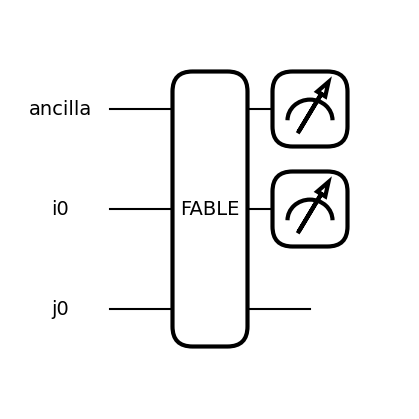

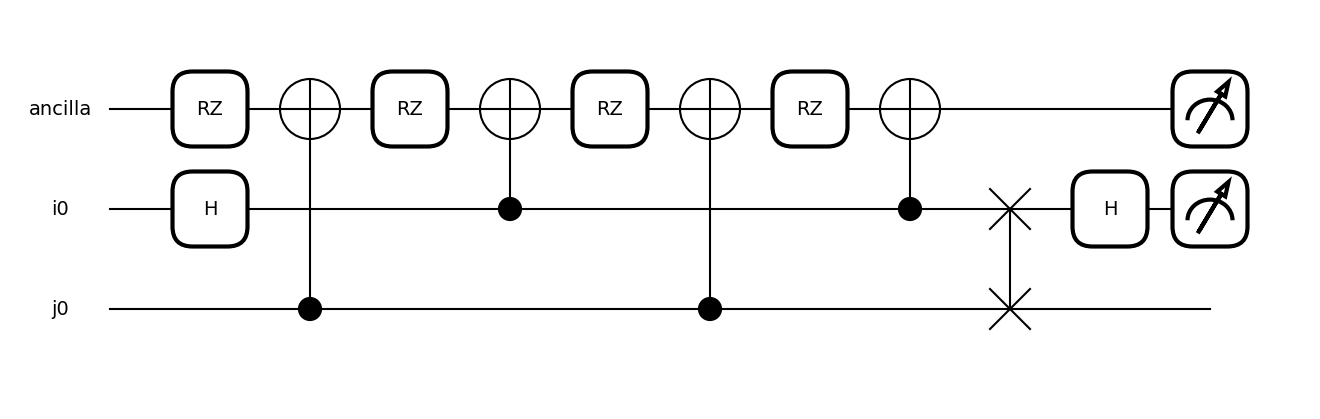

In [49]:
print(qml.draw(circuit, expansion_strategy="device")(input_norm_matrix))
fig1, ax = qml.draw_mpl(circuit)(input_norm_matrix)
fig2, ax = qml.draw_mpl(circuit, expansion_strategy="device")(input_norm_matrix)

In [31]:
print(f"Original matrix:\n{input_norm_matrix}", "\n")
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
M = (
    len(input_norm_matrix)
    * qml.matrix(circuit, wire_order=wire_order)(input_norm_matrix).real[
        :, 0 : len(input_norm_matrix), 0 : len(input_norm_matrix)
    ]
)
print(f"Block-encoded matrix:\n{M}", "\n")

Original matrix:
tensor([[[ 1.0000,  0.3826],
         [ 0.6964,  0.6841]],

        [[-0.5085, -0.0844],
         [ 1.0000, -0.2889]]]) 

Block-encoded matrix:
tensor([[[ 1.0000,  0.3826],
         [ 0.6964,  0.6841]],

        [[-0.5085, -0.0844],
         [ 1.0000, -0.2889]]], dtype=torch.float64) 

